In [1]:
from DataSimulations import simulate
from Data import DataSet
from Models.LSTM_VAR import LSTM_VAR
import logging
import Train
from Train import set_seed
import keras
from HelpComputation import *
from HelpLatex import *
from HelpPlot import *
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Experiment 6: More Complex LSTM-VAR on complex DGP

In [2]:
n, m, p = 1000, 3, 4
input_window = 32
test = 'Experiment6MoreComplexLSTMVAR'
dgp_options = ['v', 'vs', 'vts']

# Run Experiment

In [3]:
for seed in range(0, 10):
    models_results = {'metrics':[], 'gradients':[]}
    
    set_seed(seed)
    print(f'Simulation {seed}')
    simulation = simulate(n, m, p, seed=seed)
    param = simulation['parameters']
    for dgp in dgp_options:
        dataset = DataSet(simulation[dgp].values).preprocessing(1, input_window, 0.8, 0.1, scale=False)
    
        model = LSTM_VAR(output_size=dataset.X_train.shape[2],p=param['p'], units=64, scaler=dataset.scaler, lstm_stack=3,  backcast=True, linear=True)
        trained_model, model_eval = Train.train_model(model=model,dataset=dataset, param=param, epochs=200, verbose=2)
        t1 = model_eval['metrics']
        t1['model'] = '3LSTM-VAR: DGP='+dgp
        t1['simulation'] = param['seed']
        
        t2 = model_eval['gradients']
        t2['model'] = '3LSTM-VAR: DGP='+dgp
        t2['simulation'] = param['seed']
        
        models_results['metrics'].append(t1)
        models_results['gradients'].append(t2)
        if seed==0:
            # replace : with "" to avoid problems with saving
            trained_model.save(test+'/models/'+t1['model'].iloc[0].replace(':',''), save_format="tf")
        
    save(pd.concat(models_results['metrics']), f'metrics_sim{seed}', test+'/results')
    save(pd.concat(models_results['gradients']), f'gradients_sim{seed}', test+'/results')

Simulation 5
Epoch 1/200
24/24 - 6s - loss: 1.8279 - val_loss: 1.5774 - 6s/epoch - 243ms/step
Epoch 2/200
24/24 - 1s - loss: 1.4464 - val_loss: 1.3182 - 947ms/epoch - 39ms/step
Epoch 3/200
24/24 - 1s - loss: 1.2619 - val_loss: 1.2082 - 942ms/epoch - 39ms/step
Epoch 4/200
24/24 - 1s - loss: 1.1708 - val_loss: 1.1526 - 941ms/epoch - 39ms/step
Epoch 5/200
24/24 - 1s - loss: 1.1159 - val_loss: 1.1222 - 939ms/epoch - 39ms/step
Epoch 6/200
24/24 - 1s - loss: 1.0779 - val_loss: 1.1036 - 939ms/epoch - 39ms/step
Epoch 7/200
24/24 - 1s - loss: 1.0514 - val_loss: 1.0927 - 943ms/epoch - 39ms/step
Epoch 8/200
24/24 - 1s - loss: 1.0327 - val_loss: 1.0862 - 927ms/epoch - 39ms/step
Epoch 9/200
24/24 - 1s - loss: 1.0194 - val_loss: 1.0811 - 937ms/epoch - 39ms/step
Epoch 10/200
24/24 - 1s - loss: 1.0101 - val_loss: 1.0788 - 941ms/epoch - 39ms/step
Epoch 11/200
24/24 - 1s - loss: 1.0022 - val_loss: 1.0758 - 968ms/epoch - 40ms/step
Epoch 12/200
24/24 - 1s - loss: 0.9973 - val_loss: 1.0760 - 929ms/epoch - 

# Plotting

In [4]:
# TODO Remember to change based on experiment
vars = []
lstm_vars = [f'3LSTM-VAR: DGP={m}' for m in dgp_options]
counterparts = [f'LSTM-VAR: DGP={m}' for m in dgp_options] # can be list of lists if true model is known

In [5]:
order = lstm_vars + counterparts
palette = sns.color_palette("Set1", n_colors=len(order))

metrics = rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients = rename_variables(rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'gradients_sim' in file]).reset_index(drop=True)))

# Counterparts
metrics_cp = rename_columns(pd.concat([pd.read_csv('Experiment5MoreComplexDGP/results/'+file) for file in os.listdir('Experiment5MoreComplexDGP/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients_cp = rename_variables(rename_columns(pd.concat([pd.read_csv('Experiment5MoreComplexDGP/results/'+file) for file in os.listdir('Experiment5MoreComplexDGP/results') if 'gradients_sim' in file]).reset_index(drop=True)))
# Keep only the ones we want
metrics_cp = metrics_cp[metrics_cp['Model'].isin(counterparts)]
gradients_cp = gradients_cp[gradients_cp['Model'].isin(counterparts)]

metrics_all = pd.concat([metrics, metrics_cp])
gradients_all = pd.concat([gradients, gradients_cp])

## Performance over epochs

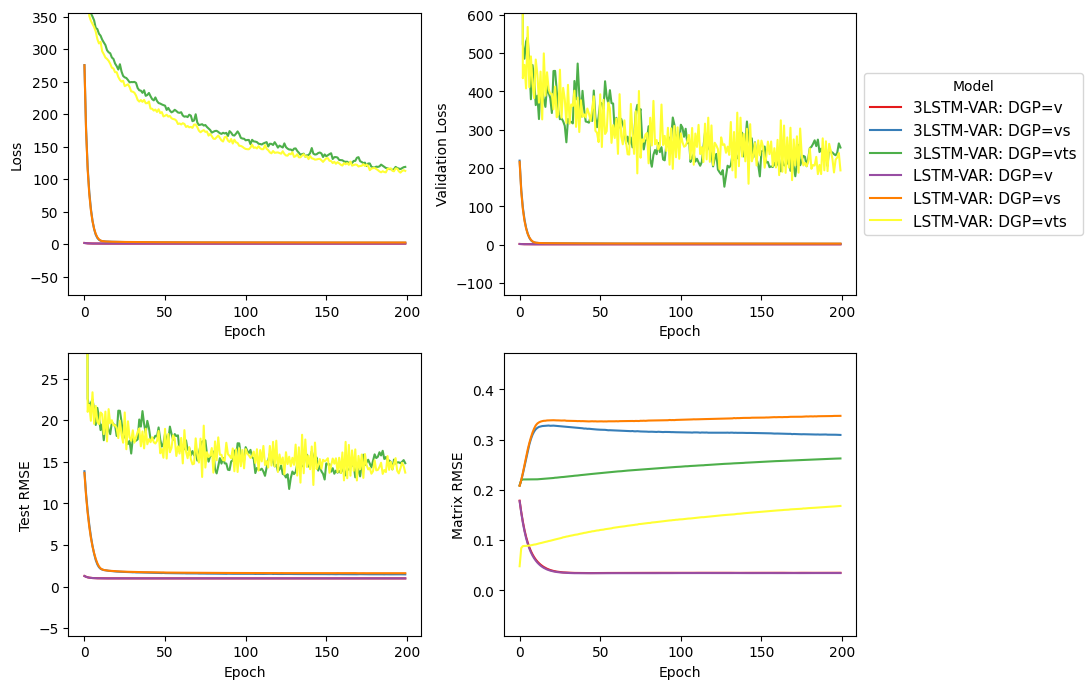

In [9]:
# 1. 2x2 metrics over epochs
fig = plot_performances_over_epochs(metrics_all, thresholds=[0.1, 0.1, 0.1, 0.1], palette=palette[:len(lstm_vars+counterparts)])
fig.savefig(test+'/epochs.png')

# Evolution of the loss, validation loss, test RMSE and matrix RMSE over Epochs

In [10]:
metrics_all.groupby(['Model', 'Epoch']).mean()[['Validation Loss', 'Matrix RMSE', 'Test RMSE',  'Same Sign %']].reset_index().groupby(['Model']).min().reindex(lstm_vars+counterparts)

,Epoch,Validation Loss,Matrix RMSE,Test RMSE,Same Sign %
Model,,,,,
3LSTM-VAR: DGP=v,0,0.959408,0.034266,0.984888,0.730556
3LSTM-VAR: DGP=vs,0,2.198303,0.208863,1.465505,0.458333
3LSTM-VAR: DGP=vts,0,151.200281,0.208413,11.730102,0.466667
LSTM-VAR: DGP=v,0,0.956638,0.033948,0.983991,0.733333
LSTM-VAR: DGP=vs,0,2.703497,0.208003,1.602013,0.491667
LSTM-VAR: DGP=vts,0,158.865424,0.047857,12.208840,0.408333


## Gradient analysis
Kernel = what handles the X
Reccurent Kernel = what handles the cell state

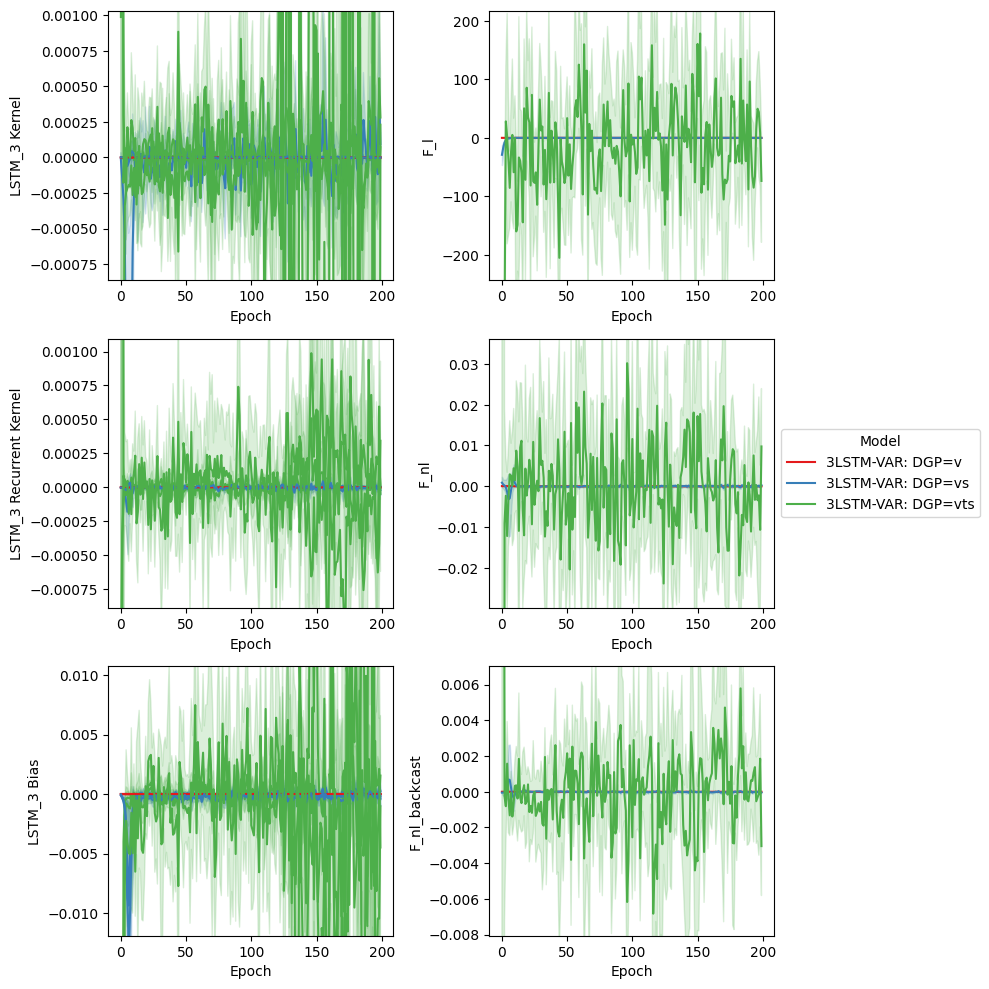

In [12]:
# 2. Gradient over epochs
# Only keep lstm_vars
fig = plot_gradients_over_epochs(gradients, palette[:len(lstm_vars)])
fig.savefig(test+'/gradients.png')

# Evolution of Gradients with Standard Deviation

## Convergence analysis
Table with mean (std), % difference (std) for matrix and val loss.

In [13]:
# 3. Convergence table
converge = compute_convergence(metrics_all)
table = converge_to_latex_table(converge, lstm_vars+counterparts)
print(table.style.to_latex())
# Convergence Metrics and Relative Change Across LSTM-VAR Models

Means: Validation Convergence  mean    48.933333
                        std     19.755000
Matrix Convergence      mean    21.733333
                        std      5.960000
Ratio                   mean     0.763333
                        std      0.273333
dtype: float64
\begin{tabular}{llll}
 & Validation Convergence & Matrix Convergence & Ratio \\
Model &  &  &  \\
3LSTM-VAR: DGP=v & 26.6 (6.15) & 48.1 (16.72) & 1.83 (0.59) \\
3LSTM-VAR: DGP=vs & 94.9 (42.97) & 9.0 (0.0) & 0.11 (0.04) \\
3LSTM-VAR: DGP=vts & 30.5 (16.46) & 9.0 (0.0) & 0.35 (0.12) \\
LSTM-VAR: DGP=v & 26.6 (6.59) & 46.3 (19.04) & 1.76 (0.69) \\
LSTM-VAR: DGP=vs & 88.8 (31.79) & 9.0 (0.0) & 0.11 (0.03) \\
LSTM-VAR: DGP=vts & 26.2 (14.57) & 9.0 (0.0) & 0.42 (0.17) \\
\end{tabular}


Statistical test to see if the relative change between convergences is significantly different between models

In [14]:
# 4. Convergence differences statistical test
groups = converge.groupby('Simulation')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between simulations')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")

groups = converge.groupby('Model')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between models')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")
print('Ratio Q3:', converge['Ratio'].quantile(0.90))

Between simulations
P-value: 0.9621402173820893 --- F-statistic: 0.32677619931256735
Between models
P-value: 3.831086552197107e-18 --- F-statistic: 45.37859314135214
Ratio Q3: 1.8498387096774194


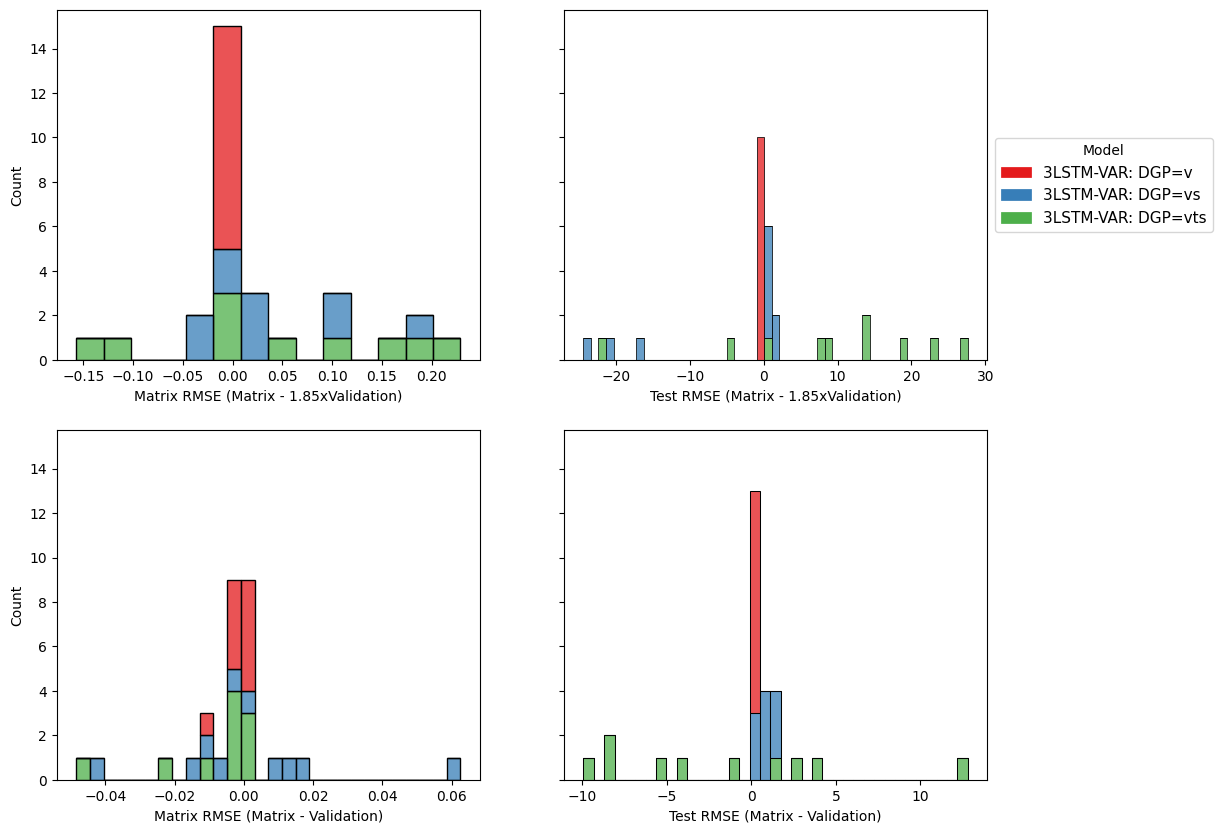

In [25]:
# 5. Convergence metric differences histogram
q3 = np.round(converge['Ratio'].quantile(0.90), 2)
est = get_converged(metrics_all, converge.set_index(['Model', 'Simulation'])['Validation Convergence']*q3, lstm_vars) # Using Q3 of ratio
mat = get_converged(metrics_all, converge.set_index(['Model', 'Simulation'])['Matrix Convergence'], lstm_vars)
val = get_converged(metrics_all, converge.set_index(['Model', 'Simulation'])['Validation Convergence'], lstm_vars)

# Difference between matrix and estimated convergence and between matrix and validation convergence
test_diff = mat[['Matrix RMSE', 'Test RMSE', 'Model', 'Simulation']].reset_index(drop=True)
test_diff.loc[:, f'Test RMSE (Matrix - {q3}xValidation)'] = test_diff['Test RMSE'] - est['Test RMSE']
test_diff.loc[:, f'Matrix RMSE (Matrix - {q3}xValidation)'] = test_diff['Matrix RMSE'] - est['Matrix RMSE']
test_diff.loc[:, 'Test RMSE (Matrix - Validation)'] = test_diff['Test RMSE'] - val['Test RMSE']
test_diff.loc[:, 'Matrix RMSE (Matrix - Validation)'] = test_diff['Matrix RMSE'] - val['Matrix RMSE']
test_diff = test_diff[test_diff.Model.isin(lstm_vars)]
# Re-order
min_diff = order_df((est.sort_values(by=['Model', 'Simulation']).set_index(['Model','Simulation'])[['Matrix RMSE', 'Test RMSE']] - metrics.groupby(['Model', 'Simulation']).min()[['Matrix RMSE', 'Test RMSE']]).reset_index(), lstm_vars)

fig = plot_convergence_differences(
    [{'df':[test_diff, test_diff], 'columns':[f'Matrix RMSE (Matrix - {q3}xValidation)', f'Test RMSE (Matrix - {q3}xValidation)'], 'hue':'Model', 'legend':True, 'palette': palette[:len(lstm_vars)]},
     {'df':[test_diff, test_diff], 'columns':['Matrix RMSE (Matrix - Validation)', 'Test RMSE (Matrix - Validation)'], 'hue':'Model', 'legend':False, 'palette': palette[:len(lstm_vars)]}])
fig.savefig(test+'/convdiff.png')

# Histograms of Differences in Convergence Metrics

In [26]:
print(test_diff.describe()[['Matrix RMSE (Matrix - Validation)', f'Matrix RMSE (Matrix - {q3}xValidation)', 'Test RMSE (Matrix - Validation)', f'Test RMSE (Matrix - {q3}xValidation)']].loc[['min','max']])

     Matrix RMSE (Matrix - Validation)  \
min                          -0.048396   
max                           0.062513   

     Matrix RMSE (Matrix - 1.85xValidation)  Test RMSE (Matrix - Validation)  \
min                               -0.157204                        -9.935270   
max                                0.228997                        12.794204   

     Test RMSE (Matrix - 1.85xValidation)  
min                            -24.462066  
max                             27.617030  


## Convergence results

Table of model, matrix sim, test mse (mean (std)), % difference
Table of statistical tests
Heatmap or joyplot plot of variable and lag eucl dist (2 parts)

In [42]:
# 6. Results table
results = pd.concat([val.drop(columns=['Loss', 'Validation Loss', 'Epoch'])])
table = results_to_latex_table(results, lstm_vars, counterparts)
print(table[['Matrix RMSE']].style.to_latex())
print(table[['Test RMSE']].style.to_latex())
print(table[['Same Sign %']].style.to_latex())
# Performance of LSTM-VAR Models and VAR Models

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Matrix RMSE} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
LSTM-VAR: DGP=v & 0.034 (0.005) & - \\
LSTM-VAR: DGP=vs & 0.339 (0.065) & - \\
LSTM-VAR: DGP=vts & 0.113 (0.041) & - \\
3LSTM-VAR: DGP=v & 0.035 (0.005) & -1.072\% \\
3LSTM-VAR: DGP=vs & 0.313 (0.057) & 7.719\% \\
3LSTM-VAR: DGP=vts & 0.23 (0.046) & -104.195\% \\
\end{tabular}

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Test RMSE} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
LSTM-VAR: DGP=v & 0.983 (0.057) & - \\
LSTM-VAR: DGP=vs & 1.63 (0.211) & - \\
LSTM-VAR: DGP=vts & 21.103 (10.634) & - \\
3LSTM-VAR: DGP=v & 0.985 (0.056) & -0.186\% \\
3LSTM-VAR: DGP=vs & 1.527 (0.175) & 6.287\% \\
3LSTM-VAR: DGP=vts & 21.963 (8.113) & -4.075\% \\
\end{tabular}

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Same Sign %} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
LSTM-VAR: DGP=v & 0.933 (0.049) & - \\
LSTM-VAR: DGP=vs & 0.661 (0.09) & - \\
LSTM-VAR: DGP=vts & 0.422 (0.094) & - \\
3LSTM-VAR: DGP=

In [43]:
# 7. Results p-values table
table = compute_p_values(results, lstm_vars, counterparts)

print(table[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].style.to_latex())
# Statistical Test Results for LSTM-VAR Models vs. VAR Model

\begin{tabular}{llll}
p-value of & Matrix RMSE & Test RMSE & Same Sign % \\
against & VAR & VAR & VAR \\
3LSTM-VAR: DGP=v & 0.552 & *0.031 & 0.758 \\
3LSTM-VAR: DGP=vs & *0.006 & *0.033 & 0.193 \\
3LSTM-VAR: DGP=vts & *0.000 & 0.746 & *0.045 \\
\end{tabular}


## Variable-wise and lag-wise RMSE

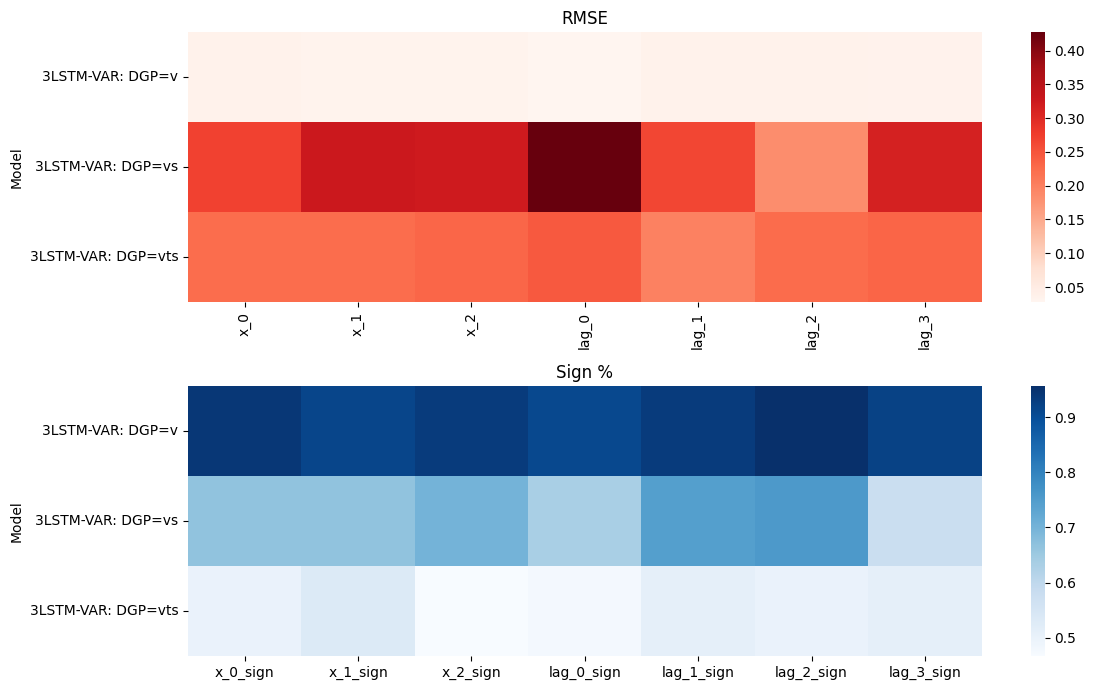

In [31]:
# 8. Variable wise and lag wise heatmap (exp2-5)
fig = plot_heatmap(results, vars, lstm_vars)
fig.savefig(test+'/lags_n_vars.png')

## Forecast breakdown

In [32]:
# 9. Breakdown of forecasts

# Read all models in test/models
models = {file:keras.models.load_model(test+'/models/'+file) for file in os.listdir(test+'/models')}
print(models.keys())

dict_keys(['3LSTM-VAR DGP=v', '3LSTM-VAR DGP=vs', '3LSTM-VAR DGP=vts'])


In [50]:
# TODO Pick model and what you want to plot
model = models['3LSTM-VAR DGP=vts']
dgp = 'vts' # v, t, s, vt, vs, ts, vts
input_window = 32 # depends on model
time_series = 0 # 0 to m-1

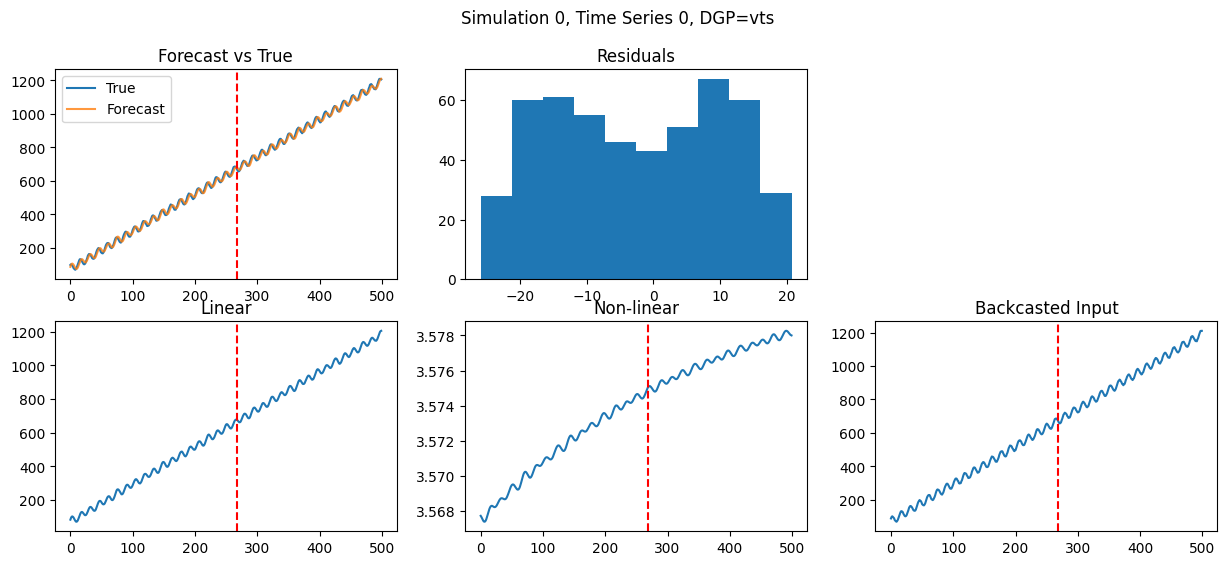

In [51]:
simulation = simulate(time_steps=1000, m=3, p=4, seed=0)
dataset = DataSet(simulation[dgp].values).preprocessing(1, input_window, 0.8, 0.1, scale=False)
fig = plot_forecast_breakdown(model, dataset, time_series, dgp)